Currently, our data contains FIPS codes. Up until now, we haven't used these codes to provide additional context. We may be able to improve model performance by encoding these into spatial coordinates. By adding spatial context in the form of latitude/longitude pairs, it will make the rows from nearby counties more similar to each other. This will allow the model to better capture the spatial context of the data.

Geocoding Resource Citation: https://github.com/josh-byster/fips_lat_long

Note: This resource is not perfect. It was missing an entry for FIPS code 51515. I manually added the entry for this FIPS Code (Bedford City, Virginia). 

In [1]:
%pip install geopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 KB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 KB 4.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import json

# Read the training and test data
train = pd.read_csv('../data/train_with_rounded_score.csv')
test = pd.read_csv('../data/test_with_rounded_score.csv')
fips_map = open('../data/fips_map.json')
fips_map = json.load(fips_map)

- Function to convert from FIPS to latitude/longitude

In [6]:
from functools import lru_cache

@lru_cache(maxsize=10000)
def fips_to_coordinate(fips_code):
    fips_code = str(fips_code)
    if fips_code in fips_map:
        return [fips_map[fips_code]['lat'], fips_map[fips_code]['long']]
    else:
        return [None, None]

In [28]:
train.columns

Index(['fips', 'date', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE', 'score'],
      dtype='object')

- Convert FIPS to latitude/longitude and concatenate to dataframe

In [7]:
#geocode all of the fips codes in train and test
train_coords = train['fips'].apply(fips_to_coordinate)
test_coords = test['fips'].apply(fips_to_coordinate)

In [8]:
#convert train coords to df
train_coords = pd.DataFrame(train_coords.tolist(), columns=['lat', 'long'])
train_coords.head()

,lat,long
0,32.532237,-86.64644
1,32.532237,-86.64644
2,32.532237,-86.64644
3,32.532237,-86.64644
4,32.532237,-86.64644


In [9]:
test_coords = pd.DataFrame(test_coords.tolist(), columns=['lat', 'long'])
test_coords.head()

,lat,long
0,32.532237,-86.64644
1,32.532237,-86.64644
2,32.532237,-86.64644
3,32.532237,-86.64644
4,32.532237,-86.64644


In [10]:
# Add the coordinates to the train and test data
train = pd.concat([train, train_coords], axis=1)
test = pd.concat([test, test_coords], axis=1)

# Drop the fips column
train = train.drop('fips', axis=1)
test = test.drop('fips', axis=1)

In [11]:
train.isna().sum()

date           0
PRECTOT        0
PS             0
QV2M           0
T2M            0
T2MDEW         0
T2MWET         0
T2M_MAX        0
T2M_MIN        0
T2M_RANGE      0
TS             0
WS10M          0
WS10M_MAX      0
WS10M_MIN      0
WS10M_RANGE    0
WS50M          0
WS50M_MAX      0
WS50M_MIN      0
WS50M_RANGE    0
score          0
lat            0
long           0
dtype: int64

In [12]:
train = train.drop(['date'],axis=1)
test = test.drop(['date'],axis=1)

- We're not missing any values as a result of the coordinate translation. We can now try to train a classifyer with the new data.

In [67]:
from catboost import CatBoostClassifier

#train classifier
model = CatBoostClassifier()
model.fit(train.drop('score', axis=1), train['score'])

Learning rate set to 0.118518
0:	learn: 1.6128390	total: 1.38s	remaining: 22m 57s
1:	learn: 1.5052395	total: 2.79s	remaining: 23m 14s
2:	learn: 1.4298348	total: 4.11s	remaining: 22m 44s
3:	learn: 1.3739466	total: 5.46s	remaining: 22m 38s
4:	learn: 1.3309678	total: 6.82s	remaining: 22m 36s
5:	learn: 1.2968174	total: 8.05s	remaining: 22m 14s
6:	learn: 1.2695716	total: 9.45s	remaining: 22m 20s
7:	learn: 1.2474689	total: 10.8s	remaining: 22m 21s
8:	learn: 1.2290599	total: 12.1s	remaining: 22m 11s
9:	learn: 1.2135557	total: 13.3s	remaining: 21m 58s
10:	learn: 1.2012652	total: 14.8s	remaining: 22m 6s
11:	learn: 1.1906244	total: 15.8s	remaining: 21m 38s
12:	learn: 1.1817658	total: 17s	remaining: 21m 29s
13:	learn: 1.1742868	total: 18s	remaining: 21m 9s
14:	learn: 1.1677300	total: 19.2s	remaining: 20m 57s
15:	learn: 1.1625126	total: 20.3s	remaining: 20m 46s
16:	learn: 1.1573730	total: 21.6s	remaining: 20m 46s
17:	learn: 1.1533329	total: 22.6s	remaining: 20m 30s
18:	learn: 1.1494534	total: 23.6

In [68]:
import pickle

#save model to file
pickle.dump(model, open('../models/catboost3_spatialEncoding_rounded_scores_no_date_no_fips.pkl', 'wb'))

In [18]:
import pickle
import pandas as pd
model = pickle.load(open('../models/catboost3_spatialEncoding_rounded_scores_no_date_no_fips.pkl','rb'))

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
preds = model.predict(test.drop('score', axis=1))

print('\nSpatial Encoding Model, no sampling adjustments')
print(classification_report(test['score'], preds))
print('F1 score:' , f1_score(test['score'], preds, average='weighted'))
print('Precision: ', precision_score(test['score'], preds, average='weighted'))
print('Recall: ', recall_score(test['score'], preds, average='weighted'))
print('Accuracy: ', accuracy_score(test['score'], preds))


Spatial Encoding Model, no sampling adjustments
              precision    recall  f1-score   support

           0       0.78      0.97      0.87    247720
           1       0.24      0.03      0.05     42486
           2       0.20      0.05      0.08     22159
           3       0.13      0.06      0.08      9590
           4       0.05      0.02      0.03      3578
           5       0.00      0.00      0.00       807

    accuracy                           0.75    326340
   macro avg       0.23      0.19      0.19    326340
weighted avg       0.64      0.75      0.67    326340

F1 score: 0.6722041225291269
Precision:  0.6409124647598368
Recall:  0.7468713611570754
Accuracy:  0.7468713611570754


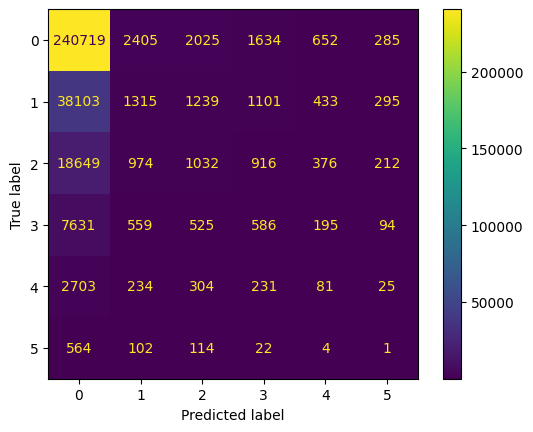

In [16]:
cm = confusion_matrix(test['score'], preds)
ConfusionMatrixDisplay(cm).plot()

In [19]:
import numpy as np
pd.Series(np.ravel(preds)).value_counts()

0    308369
1      5589
2      5239
3      4490
4      1741
5       912
dtype: int64

In [20]:
test['score'].value_counts()

0    247720
1     42486
2     22159
3      9590
4      3578
5       807
Name: score, dtype: int64

We can see that there is still a bias towards labeling 0, but metric performance has gone up significantly. Spatial encoding should be a core part of our preprocessing pipeline going forward.

However, in order to boost performance, we should combine spatial encoding with other concepts. We saw that oversampling boosted precision by 4% on the raw dataset, so that may be something we can combine with our spatial encoding.